In [2]:
from torchvision.datasets import MNIST
from matplotlib import pyplot as plt
import torch
import numpy as np
from torchvision import transforms
from torch.utils.data import DataLoader
from os.path import join
from torch import Tensor, nn
from torch.optim import SGD
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import accuracy_score

## 2 Datasets, Data Loaders, Stochastic Gradient Descent, Salvataggio e caricamento dei modelli

Finora abbiamo effettuato la discesa del gradiente calcolando i gradienti rispetto alla loss calcolata sull'intero dataset. Questaprocedura è nota come "Batch Gradient Descent". In pratica, se il dataset è molto grande, questa procedura può essereinfattibile (se il dataset è grande, potrebbe essere difficile tenerlo tutto in memoria RAM). Per superare questi limiti, è possibileutilizzare la tecnica della "Stochastic Gradient Descent" (SGD). Questa tecnica consiste nel suddividere il dataset in una seriedi mini-batch e effettuare la discesa del gradiente su un batch alla volta. Vediamo un esempio di training mediante StochasticGradient Descent considerando un esempio di dataset più grande.

Considerando il dataset MNIST:<br>
    - 70,000 immagini monocr 28x28px raffiguranti cifre scritte a mano da 0 a 9<br>
    - Ogni immagine è classificata rispetto alla cifra contenuta nell'immagine<br>
    - 60.000 immagini costituiscono trainingset<br>
    - 10.000 test set

In [3]:

# root='data' --> scarica il dataset nella sottocartella "data"
# train=true carichiamo il training set
# download = true scaricare il dataset se non è già presente nella directory specificata
mnist_train = MNIST(root='data', train=True, download=True)

# test set
mnist_test = MNIST(root='data', train=False, download=True)

Gli oggetti di tipo dataset(ne vedremo altri oltre a MNIST) si comportano in maniera simile a una lista. E' possibile determinare il numero di elementimediante la funzione len

In [4]:
print("Numero di campioni di training:", len(mnist_train))
print("Numero di campioni di test", len(mnist_test))


Numero di campioni di training: 60000
Numero di campioni di test 10000


Possiamo accedere agli elementi del dataset con l'indicizzazione.

Gli elementi del dataset sono tuple di due elementi:
    - un'immagine PIL.immagine
    - L'etichetta dell'immagine

Si noti però che, a differenza di quanto avviene con una lista, MNIST non contiene in memoria tutti i campioni, ma li caricada file dinamicamente quando essi vengono richiesti. Ciò permette di lavorare efficientemente con dataset molto grandi(anche milioni di immagini). Possiamo visualizzare le immagini di PIL mediante matplotlib

(<PIL.Image.Image image mode=L size=28x28 at 0x152D2E9D0>, 5)
(<PIL.Image.Image image mode=L size=28x28 at 0x152D2E130>, 7)
dato: <class 'PIL.Image.Image'>
etichetta: <class 'int'>


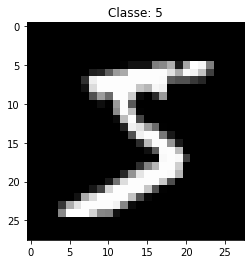

In [5]:
# indicizzazione
print(mnist_train[0])
print(mnist_test[0])
print("dato:", type(mnist_train[0][0]))
print("etichetta:", type(mnist_train[0][1]))


#cmap='gray' serve per evitare di visualizzare le immagini in falsi colori
plt.imshow(mnist_train[0][0],cmap='gray')
plt.title("Classe: "+str(mnist_train[0][1]))
plt.show()

Per lavorare su immagini dobbiamo prima trasformarle in tenstori. Si può fare ciò 
- convertendo l'immagine in un array di numpy
- successivamente convertire in un tensore


In [6]:
im = torch.from_numpy(np.array(mnist_train[0][0]))
im.shape # l'immagine è un tensore a 28x28 px

torch.Size([28, 28])

Questa operazione dovrà essere effettuata su tutti gli elementi del dataset. Per automatizzare questa operazione, PyTorchpermette di specificare una funzione di trasformazione, ovvero una funzione che verrà applicata a tutti gli elementi del dataset"al volo" quando questi vengono richiesti:Per trasformare le immagini di PIL in tensori di PyTorch, specifichiamo l'oggetto torchvision.transforms.ToTensor()come trasformazione al costruttore di MNIST:

In [7]:
mnist_train = MNIST(root='data',train=True, download=True,transform=transforms.ToTensor())

mnist_test = MNIST(root='data',train=False, download=True,transform=transforms.ToTensor())

sample = mnist_train[0]
print(type(sample[0]), type(sample[1]))
print("shape:", mnist_train[0][0].shape)

<class 'torch.Tensor'> <class 'int'>
shape: torch.Size([1, 28, 28])


Sarà dunque un tensore 1 x 28 x 28 dove:
- 1 indica che l'immagine è in scala di grigi (RGB 3 canali)
- 28x28 le dimensioni delle immagini

La dimensione aggiuntiva "1" viene aggiunta in auto dall'oggetto ToTensor per compatibilità con le immagini a colori. Mostrando alcune immagini con matplotlib:

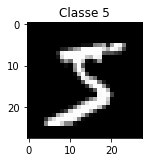

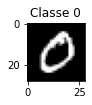

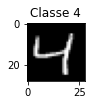

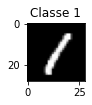

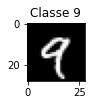

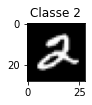

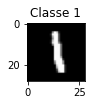

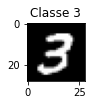

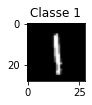

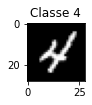

In [8]:
plt.figure(figsize=(12,5.5))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.title("Classe %d" % mnist_train[i][1])
    plt.imshow(mnist_train[i][0].squeeze().numpy(), cmap='gray')    ## squeeze trasforma il tensore 1 x 28 x 28 in tensore 28x28

    plt.show()

Per poter allenare un classificatore su questi dati, abbiamo bisogno di normalizzarli in modo che:
- media nulla
- deviazione standard unitaria

Calcoliamo dunque media e varianza dei pixel contenuti in tutte le immagini del training set:

In [9]:
m = 0
for sample in mnist_train:
    m+=sample[0].sum()  # accumuliamo somma di tutti i pixel

m = m / (len(mnist_train)*28*28)

# calcolo dev std
s = 0
for sample in mnist_train:
    s+=((sample[0]-m)**2).sum()

s = np.sqrt(s/(len(mnist_train)*28*28))

print("Valori trovati:", "Mean: %0.4f"%m, "Std: %0.4f"%s)

Valori trovati: Mean: 0.1307 Std: 0.3081


Questa procedura può essere effettuata da qualsiasi dataset ed è necessario effettuarla solo una volta. In seguito è possibile conservare questi valori e utilizzarli direttamente per normalizzare i dati. Possiamo dunque normalizzare un singolo campione come segue:

In [10]:
sample=(mnist_train[15][0]-m)/s
print("Minimo: ", sample.min(), "\nMassimo: ", sample.max(), "\nMedia: ", sample.mean, "\nDev. std: ",sample.std)

Minimo:  tensor(-0.4241) 
Massimo:  tensor(2.8215) 
Media:  <built-in method mean of Tensor object at 0x152e8b580> 
Dev. std:  <built-in method std of Tensor object at 0x152e8b580>


Per evitare di effettuare questa operazione in maniera manuale, possiamo specificare l'oggetto `transforms.Normalize` come trasformazione all'oggetto dataset. Abbiamo però bisogno di combinare la nuova trasformazione con la trasformazione ToTensor. Per farlo usiamo l'oggetto `transforms.Compose`

In [11]:
# Compose prende in input una lista di trasformazioni

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((m,),(s,))])

mnist_train = MNIST(root='data', train=True, download=True, transform=transform)
mnist_test = MNIST(root='data', train=False, download=True, transform=transform)

Calcoliamo qualche statistica su uno degli elementi del dataset

In [12]:

sample=mnist_train[15][0]
print("Minimo:",sample.min())
print("Massimo:",sample.max())
print("Media:",sample.mean())
print("Dev. Std.:",sample.std())

Minimo: tensor(-0.4241)
Massimo: tensor(2.8215)
Media: tensor(-0.0134)
Dev. Std.: tensor(0.9860)


Ogni immagine è adesso rappresentata da un tensore 1 x 28 x 28 . Fin'ora abbiamo visto solo algoritmi come ad es. il regressore softmax che lavorano su vettori unidimensionali di dati. Per poter lavorare sulle immagini con questi metodi possiamo trasformare le immagini 28 x 28 in vettori di 784 dimensioni come segue:

In [13]:
sample = sample.view(-1)
print(sample.shape)

torch.Size([784])


Se vogliamo effettuare anche questa operazione in automatico mediante le trasformazioni, possiamo definirne una "custom" usando la funzione torch.vision.Lambda 

In [14]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((m,),(s,)),
                                torch.flatten]) 
                                #transforms.Lambda(lambda x: x.view(-1))])   ## specifichiamo l'operazione "custom"



mnist_train = MNIST(root='data', train=True, download=True, transform=transform)

mnist_test = MNIST(root='data', train=False, download=True, transform=transform)

print(mnist_train[0][0].shape)
print(mnist_train[0][1])

print(type(mnist_test))

torch.Size([784])
5
<class 'torchvision.datasets.mnist.MNIST'>


## Data Loader

Ogni campione ottenuto mediante l'oggetto dataset MNIST verrà automaticamente normalizzato e trasformato in un vettore.Per effettuare l'ottimizzazione mediante Stochastic Gradient Descent, dobbiamo suddividere i campioni in mini-batch. Inoltre,è importante fornire i campioni in ordine casuale, in quanto fornire consecutivamente elementi con caratteristiche simili (es.stessa classe) favorirebbe l'overfitting. PyTorch ci permette di gestire il "batching" in automatico e in maniera multithreadmediante l'oggetto DataLoader. Utilizziamo un batch size di     immagini e due thread paralleli per velocizzare ilcaricamento dei dati:



In [15]:
print(type(mnist_test))

mnist_train_loader = DataLoader(mnist_train, batch_size=256, num_workers=2, shuffle=True) 
#shuffle permette di accedere ai dati in maniera casuale 
mnist_test_loader= DataLoader(mnist_test, batch_size=256, num_workers=2)

print(mnist_test_loader)

I data loader sono degli oggetti iterabili. Possiamo dunque accedere ai diversi batch in maniera sequenziale all'interno di unciclo for. Il ciclo terminerà quando tutti i batch del dataset saranno stati caricati. Proviamo ad accedere al primo batch einterrompiamo il ciclo:

In [15]:
for batch in mnist_test_loader:
    pass

print(batch[0].shape)
print(batch[1].shape)

torch.Size([16, 784])
torch.Size([16])


Il batch contiene 256 vettori di training di dimensione 784 e altrettante etichette corrispondenti. Se il numero di elementi del dataset non è multiplo del batch size, l'ultimo batch sarà di dimensioni inferiori. Proviamo ad iterare tutto il loader e vediamo quanti elementi contiene l'ultimo batch:

In [16]:
for batch in mnist_test_loader:
    pass    ## eq a continue

print(batch[0].shape)
print(batch[1].shape)

torch.Size([16, 784])
torch.Size([16])


## Log di loss e accuracy e SGD

testo ed eq in pdf.

Questi calcoli possono essere automatizzati mediante un oggetto chiamato Meter:

In [17]:
class AverageValueMeter():
    def __init__(self):
        self.reset()

    def reset(self):
        self.sum = 0
        self.num = 0

    def add(self, value, num):
        self.sum += value*num
        self.num += num

    def value(self):
        try:
            return self.sum/self.num
        except:
            return None

Utilizziamo dunque la classe appena definita:

In [18]:
meter = AverageValueMeter()

meter.add(10, 3) #inseriamo il valore 10, calcolato da un batch di 3 elementi
meter.add(3,5) 
meter.add(-1,2)

# media pesata calcolata manualmente
print('Media pesata calcolata manualmente:',(10*3+3*5-1*2)/(3+5+2))
print('Media pesata calcolata mediante meter:',meter.value())

Media pesata calcolata manualmente: 4.3
Media pesata calcolata mediante meter: 4.3


è possibile ripristinare un meter ai valori iniziali con il metodo reset

In [19]:
meter.reset()
print(meter.value())

None


Il meter creato ci permette di ottenere una stima corrente di loss e accuracy. Dato che una epoca di training può richiedereanche diverse ore a seconda del dataset e del momento, loggeremo queste stime ad ogni iterazione. In questo caso,utilizzeremo come global_step il numero totale di campioni attualmente "visti" durante il training.

In [20]:
class SoftMaxRegressor(nn.Module):
    def __init__(self, in_features, out_classes):
        """Costruisce un regressore softmax
            Input:
                in_features: numero di feature in input (es.4)
                out_classes: numero di classi in uscita (es.3) """
        super(SoftMaxRegressor, self).__init__()    ## richiamo costruttore della superclasse, passo necessario per abilitare alcuni meccanismi automatici di PyTorch

        self.linear = nn.Linear(in_features, out_classes)   ## il regressore softmax restituisce distr di probabilità, quindi il numero di feature di output coincide con il numero di classi. è lineare in quanto il softmax viene implementato nella loss

    def forward(self,x):
        """Definisce come processare l'input x"""
        scores = self.linear(x)
        return scores

In [21]:
def train_classifier(model, train_loader, test_loader, exp_name='experiment', lr=0.001, epochs=10, momentum=0.9, logdir='logs'):

    criterion = nn.CrossEntropyLoss()
    optimizer = SGD(model.parameters(), lr, momentum=momentum)

    # meters
    loss_meter = AverageValueMeter()
    acc_meter = AverageValueMeter()
    # writer
    writer = SummaryWriter(join(logdir, exp_name))
    # device
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)
    ## definiamo un dizionario contenente i loader di training e test
    loader = {
        'train': train_loader,
        'test': test_loader
    }
    global_step = 0
    for e in range(epochs):
        # iteriamo tra due modalità: train e test
        for mode in ['train', 'test']:
            loss_meter.reset(); acc_meter.reset()
            model.train() if mode == 'train' else model.eval()
            with torch.set_grad_enabled(mode=='train'): # abilitiamo i gradienti o solo in training
                for i, batch in enumerate(loader[mode]):
                    x=batch[0].to(device) # portiamoli su device corretto
                    y=batch[1].to(device)
                    output = model(x)

                    # aggiorniamo il global_step
                    # conterrà il numero di campioni visti durante il training
                    n = x.shape[0]  # n di elementi nel batch
                    global_step += n
                    l = criterion(output, y)

                    if mode=='train':
                        l.backward()
                        optimizer.step()
                        optimizer.zero_grad()

                    acc = accuracy_score(y.to('cpu'), output.to('cpu').max(1)[1])
                    loss_meter.add(l.item(), n)
                    acc_meter.add(acc,n)

                    # loggiamo i risultati iterazione per iterazione solo durante il training
                    if mode == 'train':
                        writer.add_scalar('loss/train', loss_meter.value(), global_step=global_step)
                        writer.add_scalar('accuracy/train', acc_meter.value(), global_step=global_step)

                        # una volta finita l'epoca sia nel caso di training che di test loggiamo le stime finali

                writer.add_scalar('loss/' + mode, loss_meter.value(), global_step=global_step)
                writer.add_scalar('accuracy/' + mode, acc_meter.value(), global_step=global_step)

                        ## conserviamo i pesi del modello alla fine di un ciclo di training e test

        torch.save(model.state_dict(), '%s-%d.pth'%(exp_name, e+1))
    return model


alleniamo il modello:

In [22]:
lr = 0.01
epochs = 10
momentum = 0.9

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((m,),(s,)),
                                torch.flatten
                                ])

mnist_train = MNIST(root='data', train=True, download=True, transform=transform)
mnist_test = MNIST(root='data', train=False, download=True, transform=transform)

mnist_train_loader = DataLoader(mnist_train, batch_size=256, num_workers=2, shuffle=True)
mnist_test_loader = DataLoader(mnist_test, batch_size=256, num_workers=2)

model = SoftMaxRegressor(784, 10)

model = train_classifier(model, mnist_train_loader, mnist_test_loader, 'files/SGD-softmax-regressor', lr=lr, epochs=epochs, momentum=momentum)

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


Per valutare la performance del modello, dobbiamo prima ottenere le predizioni per ciascuno degli elementi di test. Definiamo la seguente funzione

In [23]:
def test_classifier(model, loader):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)
    predictions, labels = [], []
    for batch in loader:
        x = batch[0].to(device)
        y = batch[1].to(device)
        output = model(x)
        preds = output.to('cpu').max(1)[1].numpy()
        labs = y.to('cpu').numpy()
        predictions.extend(list(preds))
        labels.extend(list(labs))
    
    return np.array(predictions), np.array(labels)

Possiamo dunque ottenere le predizioni di training e test e valutare il modello con le misure di valutazione che preferiamo. ad esempio mediante accuracy

In [24]:
predictions_train, labels_train = test_classifier(model, mnist_test_loader)
predictions_test, labels_test = test_classifier(model, mnist_test_loader)
print("Accuracy di training: %0.4f"% accuracy_score(labels_train, predictions_train))
print("Accuracy di test: %0.4f"% accuracy_score(labels_test, predictions_test))

Accuracy di training: 0.9238
Accuracy di test: 0.9238
